In [1]:
from smallBixTools import smallBixTools as st


In [2]:
from pathlib import Path


def file_path(filename: str, root: str='.') -> Path:
    """
    Makes specifying a file's path more convenient
    :param filename: full literal filename
    :param root: directory from where to perform recursive search for filename
    :return: path object of filename
    :raises: FileNotFoundError if no unique match is found
    """
    path_matches = tuple(Path(root).rglob(filename))
    if len(path_matches) == 1:
        return path_matches[0]
    else:
        raise FileNotFoundError(
            f'A unique match is required, however {len(path_matches)} matches '
            f'were found.'
        )


In [3]:
# Move data into a format that is easily compatible with pandas, which might be
# used later on
fasta_dict = dict()
fasta_dict.update(st.fasta_to_dct(file_path('CAP177_ENV_C1C2_reference.fasta')))
fasta_dict.update(st.fasta_to_dct(file_path('CAP177_ENV_C1C2.fasta')))
fasta_list = [{'sequence_id': k, 'sequence': v} for k, v in fasta_dict.items()]
fasta_list[:5]


[{'sequence_id': 'CAP177_ENV_C1C2_reference',
  'sequence': 'TTAAAGTGTACA---------------------------------------------------------------------------------------------AATACTACCTATTATAATGTTAGCAGCAAGGAAGAAATAAAAAATTGCTCTTTCAATACAACCACAGAAATAAGGGATAAGAAACAGCAAGCATATGCACTTTTTTATAGACCTGATATAGTACCACTTAATGAGAATAAT---GATAGC------TATATATTAATAAATTGCAATACCTCAACCATTACACAGGCCTGTCCAAAGGTCACTTTTGACCCGATTCCTATACATTATTGTGCT'},
 {'sequence_id': 'CAP177_2000_004wpi_C1C2_001_0.853',
  'sequence': 'TTAAAGTGTACA---------------------------------------------------------------------------------------------AATACTACCTATTATAATGTTAGCAGCAAGGAAGAAATAAAAAATTGCTCTTTCAATACAACCACAGAAATAAGGGATAAGAAACAGCAAGCATATGCACTTTTTTATAGACCTGATATAGTACCACTTAATGAGAATAAT---GATAGC------TATATATTAATAAATTGCAATACCTCAACCATTACACAGGCCTGTCCAAAGGTCACTTTTGACCCGATTCCTATACATTATTGTGCT'},
 {'sequence_id': 'CAP177_2000_004wpi_C1C2_002_0.075',
  'sequence': 'TTAAAGTGTACA-------------------------------------------------------------------------------------

In [4]:
# Going forward I might prefer to do this work using pandas
# But this demonstrates a pure python way of doing it,
# Later on I will demonstrate similar manipulations using pandas

def unpack_sequence_id(sequence_id: str) -> dict:
    """
    Derives key value pairs from the sequence id
    :param sequence_id: sequence id to be interpreted
    :return: a dict of key/values derived from the sequence id
    """
    if sequence_id == 'CAP177_ENV_C1C2_reference':
        # Naming convention is different for reference sequence
        # Maybe a bit hacky, but overiding the sequence_id with
        # the values we care about, we keep the original sequence
        # id as is, so can easily still refer to the reference sequence
        sequence_id = 'CAP177_C1C2'
        sequence_id_keys = (
            'participant_id',
            'gene_region'
        )
    else:
        sequence_id_keys = (
            'participant_id',
            'visit_code',
            'weeks_post_infection',
            'gene_region',
            'unique_numeric_tag',
            'relative_frequency_at_time'
        )
    sequence_id_split = sequence_id.split('_')
    if len(sequence_id_keys) is not len(sequence_id_split):
        raise ValueError(
            f'Number of sequence id keys, {len(sequence_id_keys)} do not match'
            f'number of sequence id values, {len(sequence_id_split)}'
        )
    return dict(zip(sequence_id_keys, sequence_id_split))


def sanitize_value_types(item: dict):
    """
    Corrects some of the value types to be more usable
    :param item: dictionary item to be corrected
    :return: a dict with value types sanitized
    """
    if item['sequence_id'] == 'CAP177_ENV_C1C2_reference':
        pass
    else:
        item['weeks_post_infection'] = int(
            item['weeks_post_infection'].split('wpi')[0]
        )
        item['relative_frequency_at_time'] = float(
            item['relative_frequency_at_time']
        )
        item['unique_numeric_tag'] = int(item['unique_numeric_tag'])


# This could probably be done more expressively in Pandas
def calculate_hamming(item: dict):
    """
    Calculates the hamming distance between item's sequence and that
    of the reference
    :param item: dictionary item containing sequence to be compared against reference
    :return: a dict updated with hamming distance key/value
    """
    if item['sequence_id'] == 'CAP177_ENV_C1C2_reference':
        pass
    else:
        item['hamming_distance'] = st.hamdist(
            item['sequence'], fasta_list[0]['sequence']
        )


In [5]:
# Format data contents so that plotting can be carried out later on
for item in fasta_list:
    item.update(unpack_sequence_id(item['sequence_id']))
    sanitize_value_types(item)
    calculate_hamming(item)
fasta_list[:5]


[{'sequence_id': 'CAP177_ENV_C1C2_reference',
  'sequence': 'TTAAAGTGTACA---------------------------------------------------------------------------------------------AATACTACCTATTATAATGTTAGCAGCAAGGAAGAAATAAAAAATTGCTCTTTCAATACAACCACAGAAATAAGGGATAAGAAACAGCAAGCATATGCACTTTTTTATAGACCTGATATAGTACCACTTAATGAGAATAAT---GATAGC------TATATATTAATAAATTGCAATACCTCAACCATTACACAGGCCTGTCCAAAGGTCACTTTTGACCCGATTCCTATACATTATTGTGCT',
  'participant_id': 'CAP177',
  'gene_region': 'C1C2'},
 {'sequence_id': 'CAP177_2000_004wpi_C1C2_001_0.853',
  'sequence': 'TTAAAGTGTACA---------------------------------------------------------------------------------------------AATACTACCTATTATAATGTTAGCAGCAAGGAAGAAATAAAAAATTGCTCTTTCAATACAACCACAGAAATAAGGGATAAGAAACAGCAAGCATATGCACTTTTTTATAGACCTGATATAGTACCACTTAATGAGAATAAT---GATAGC------TATATATTAATAAATTGCAATACCTCAACCATTACACAGGCCTGTCCAAAGGTCACTTTTGACCCGATTCCTATACATTATTGTGCT',
  'participant_id': 'CAP177',
  'visit_code': '2000',
  'weeks_post_infection': 4,
  'gene_region': 'C1C2',
  'u

In [6]:
# Export all data to CSV, including derived columns
import csv

columns = set(list(fasta_list[0].keys()) + list(fasta_list[1].keys()))
with open('sequence_data_pre_pandas.csv', 'w') as output_file:
    dict_writer = csv.DictWriter(output_file, columns)
    dict_writer.writeheader()
    dict_writer.writerows(fasta_list)


In [7]:
# Utilize pandas for expressive data manipulations
import pandas as pd

df = pd.DataFrame(fasta_list)


In [8]:
df.head()


gene_region  hamming_distance participant_id  relative_frequency_at_time  \
0        C1C2               NaN         CAP177                         NaN   
1        C1C2               0.0         CAP177                       0.853   
2        C1C2              14.0         CAP177                       0.075   
3        C1C2               1.0         CAP177                       0.025   
4        C1C2               1.0         CAP177                       0.010   

                                            sequence  \
0  TTAAAGTGTACA----------------------------------...   
1  TTAAAGTGTACA----------------------------------...   
2  TTAAAGTGTACA----------------------------------...   
3  TTAAAGTGTACA----------------------------------...   
4  TTAAAGTGTACA----------------------------------...   

                         sequence_id  unique_numeric_tag visit_code  \
0          CAP177_ENV_C1C2_reference                 NaN        NaN   
1  CAP177_2000_004wpi_C1C2_001_0.853                 1.0       2000   
2  CAP177_2000_004wpi_C1C2_002_0.075                 2.0       2000   
3  CAP177_2000_004wpi_C1C2_003_0.025                 3.0       2000   
4  CAP177_2000_004wpi_C1C2_004_0.010                 4.0       2000   

   weeks_post_infection  
0                   NaN  
1                   4.0  
2                   4.0  
3                   4.0  
4                   4.0

In [9]:
df.dtypes


gene_region                    object
hamming_distance              float64
participant_id                 object
relative_frequency_at_time    float64
sequence                       object
sequence_id                    object
unique_numeric_tag            float64
visit_code                     object
weeks_post_infection          float64
dtype: object

In [10]:
# Pandas provides a much more simple way to export to CSV
df.to_csv('hamming.csv', columns=['sequence_id', 'weeks_post_infection', 'hamming_distance'])

In [11]:
%matplotlib inline
# An observation is that with each change in 'visit_code' (and therefore wpi), the 'unique_numeric_tag' resets to 1.
# All the data belongs to a single participant, from a single gene region
# To plot a graph, we would want to group data by wpi, then plot the min, max, 95th percentile, etc hamming distance with respect to wpi


In [12]:
# TODO: Work out pandas syntax to display values side by side
print(df.groupby(['weeks_post_infection'])['hamming_distance'].max())
print(df.groupby(['weeks_post_infection'])['hamming_distance'].mean())
print(df.groupby(['weeks_post_infection'])['hamming_distance'].min())

weeks_post_infection
4.0       34.0
6.0       26.0
7.0       15.0
9.0       15.0
11.0      15.0
13.0      16.0
36.0      23.0
41.0      37.0
46.0      51.0
50.0      57.0
54.0      64.0
67.0      91.0
80.0      82.0
93.0      83.0
107.0     83.0
120.0     85.0
133.0     83.0
146.0     84.0
159.0     73.0
172.0    102.0
Name: hamming_distance, dtype: float64
weeks_post_infection
4.0       5.182927
6.0      11.212121
7.0       4.651163
9.0       5.621622
11.0      9.250000
13.0      7.890909
36.0     13.901786
41.0     17.288235
46.0     22.208696
50.0     24.656442
54.0     29.259912
67.0     34.286174
80.0     38.027701
93.0     49.013274
107.0    56.732673
120.0    56.553623
133.0    57.964286
146.0    58.230038
159.0    62.317554
172.0    62.170358
Name: hamming_distance, dtype: float64
weeks_post_infection
4.0       0.0
6.0       0.0
7.0       0.0
9.0       0.0
11.0      0.0
13.0      0.0
36.0      1.0
41.0      2.0
46.0      2.0
50.0      7.0
54.0      7.0
67.0     12.0
80.0     13

Text(0,0.5,'hamming distance')

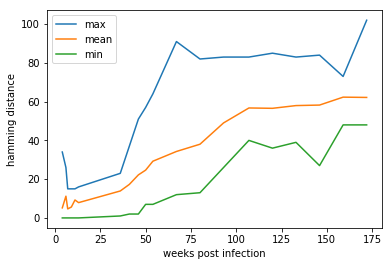

In [13]:
fig_a = df.groupby(['weeks_post_infection'])['hamming_distance'].max().plot.line(legend=True, label='max')
fig_a = df.groupby(['weeks_post_infection'])['hamming_distance'].mean().plot.line(legend=True, label='mean')
fig_a = df.groupby(['weeks_post_infection'])['hamming_distance'].min().plot.line(legend=True, label='min')
fig_a.set_xlabel('weeks post infection')
fig_a.set_ylabel('hamming distance')


In [14]:
save_fig_a = fig_a.get_figure()
save_fig_a.savefig('hamming_vs_wpi.pdf')

Text(0,0.5,'hamming distance')

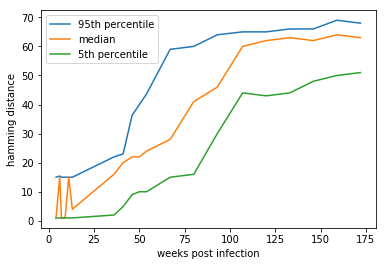

In [15]:
fig_b = df.groupby(['weeks_post_infection'])['hamming_distance'].quantile(0.95).plot.line(legend=True, label='95th percentile')
fig_b = df.groupby(['weeks_post_infection'])['hamming_distance'].median().plot.line(legend=True, label='median')
fig_b = df.groupby(['weeks_post_infection'])['hamming_distance'].quantile(0.05).plot.line(legend=True, label='5th percentile')
fig_b.set_xlabel('weeks post infection')
fig_b.set_ylabel('hamming distance')


In [16]:
total_sequences = df.sequence.size
total_sequences


4745

In [17]:
unique_sequences = df.sequence.unique().size
unique_sequences


4295

In [18]:
# Interesting that most sequences are unique. TODO: Would like to
# explore similarities amongst the recurring ones.


In [19]:
# In this tutorial:
# https://towardsdatascience.com/starting-off-in-bioinformatics-dna-nucleotides-and-strands-8c32515271a8
# they seem to place value in counting each of
# the nucleotides and complementary sequences

# I will go about adding some further columns to the dataframe
# with counts of each nucleotide and explore what insight that may provide


In [20]:
# Adding columns derived from dataframes is arguably more
# straight forward than doing it the pure python way as before
df['count_A'] = df['sequence'].str.count('A')
df['count_C'] = df['sequence'].str.count('C')
df['count_G'] = df['sequence'].str.count('G')
df['count_T'] = df['sequence'].str.count('T')
df['count_-'] = df['sequence'].str.count('-')
df['sequence_length'] = df['sequence'].str.len()


In [21]:
df['percent_A'] = df['count_A'].divide(df['sequence_length']).multiply(100)
df['percent_C'] = df['count_C'].divide(df['sequence_length']).multiply(100)
df['percent_G'] = df['count_G'].divide(df['sequence_length']).multiply(100)
df['percent_T'] = df['count_T'].divide(df['sequence_length']).multiply(100)
df['percent_-'] = df['count_-'].divide(df['sequence_length']).multiply(100)


In [22]:
df.head()


gene_region  hamming_distance participant_id  relative_frequency_at_time  \
0        C1C2               NaN         CAP177                         NaN   
1        C1C2               0.0         CAP177                       0.853   
2        C1C2              14.0         CAP177                       0.075   
3        C1C2               1.0         CAP177                       0.025   
4        C1C2               1.0         CAP177                       0.010   

                                            sequence  \
0  TTAAAGTGTACA----------------------------------...   
1  TTAAAGTGTACA----------------------------------...   
2  TTAAAGTGTACA----------------------------------...   
3  TTAAAGTGTACA----------------------------------...   
4  TTAAAGTGTACA----------------------------------...   

                         sequence_id  unique_numeric_tag visit_code  \
0          CAP177_ENV_C1C2_reference                 NaN        NaN   
1  CAP177_2000_004wpi_C1C2_001_0.853                 1.0       2000   
2  CAP177_2000_004wpi_C1C2_002_0.075                 2.0       2000   
3  CAP177_2000_004wpi_C1C2_003_0.025                 3.0       2000   
4  CAP177_2000_004wpi_C1C2_004_0.010                 4.0       2000   

   weeks_post_infection  count_A  count_C  count_G  count_T  count_-  \
0                   NaN       96       45       34       71      102   
1                   4.0       96       45       34       71      102   
2                   4.0      100       44       37       74       93   
3                   4.0       96       44       34       72      102   
4                   4.0       97       45       34       70      102   

   sequence_length  percent_A  percent_C  percent_G  percent_T  percent_-  
0              348  27.586207  12.931034   9.770115  20.402299  29.310345  
1              348  27.586207  12.931034   9.770115  20.402299  29.310345  
2              348  28.735632  12.643678  10.632184  21.264368  26.724138  
3              348  27.586207  12.643678   9.770115  20.689655  29.310345  
4              348  27.873563  12.931034   9.770115  20.114943  29.310345

In [23]:
df.groupby(['weeks_post_infection'])[['percent_C', 'percent_A', 'percent_G', 'percent_T', 'percent_-']].mean()


percent_C  percent_A  percent_G  percent_T  percent_-
weeks_post_infection                                                       
4.0                   12.843426  27.705355   9.945332  20.458368  29.047519
6.0                   12.695925  28.335075  10.370951  20.968304  27.629746
7.0                   12.884256  27.920342  10.010692  20.522588  28.662122
9.0                   12.806772  27.935694   9.987574  20.588692  28.681267
11.0                  12.751437  28.232759  10.314895  20.887213  27.813697
13.0                  12.800418  28.140021  10.182863  20.747126  28.129572
36.0                  12.846367  28.943452  10.442323  20.810242  26.957615
41.0                  13.049358  29.447262  10.474983  21.095335  25.933063
46.0                  13.163418  29.765117  10.617191  21.414293  25.039980
50.0                  13.366476  30.184754  10.690360  21.689232  24.069177
54.0                  13.613348  30.445845  10.833460  22.028963  23.078384
67.0                  13.738589  30.529992  10.856710  22.024799  22.849909
80.0                  14.050212  30.500366  10.809692  22.218773  22.420957
93.0                  14.528024  31.633354  10.979300  23.653494  19.205829
107.0                 14.977381  32.745818  11.024098  23.927393  17.325310
120.0                 14.837581  33.164251  10.957021  24.137098  16.904048
133.0                 14.592863  33.312075  11.209829  24.541110  16.344124
146.0                 14.692321  33.444233  11.074691  24.589725  16.199030
159.0                 14.622866  33.533973  11.099776  24.844136  15.899250
172.0                 14.829936  33.726918  11.110458  24.630402  15.702285

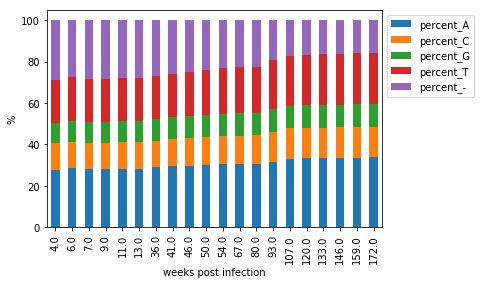

In [24]:
fig_c = df.groupby(['weeks_post_infection'])[['percent_A', 'percent_C', 'percent_G', 'percent_T', 'percent_-']].mean().plot.bar(stacked=True)
fig_c.set_xlabel('weeks post infection')
fig_c.set_ylabel('%')
fig_c.legend(bbox_to_anchor=(1,1))


In [25]:
# Would like to explore more about why these gaps would diminish over time.
# TODO: Learn more about how to effectively tell a story about what this data shows. Need to brush up on my stats!


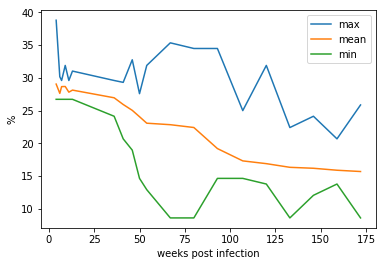

In [26]:
fig_d = df.groupby(['weeks_post_infection'])['percent_-'].max().plot.line(legend=True, label='max')
fig_d = df.groupby(['weeks_post_infection'])['percent_-'].mean().plot.line(legend=True, label='mean')
fig_d = df.groupby(['weeks_post_infection'])['percent_-'].min().plot.line(legend=True, label='min')
fig_d.set_xlabel('weeks post infection')
fig_d.set_ylabel('%')
fig_d.legend(bbox_to_anchor=(1,1))


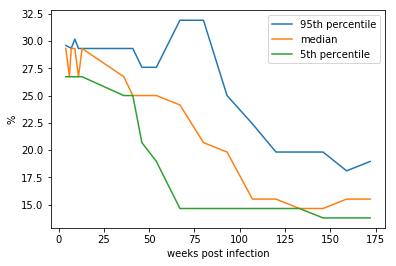

In [27]:
fig_e = df.groupby(['weeks_post_infection'])['percent_-'].quantile(0.95).plot.line(legend=True, label='95th percentile')
fig_e = df.groupby(['weeks_post_infection'])['percent_-'].median().plot.line(legend=True, label='median')
fig_e = df.groupby(['weeks_post_infection'])['percent_-'].quantile(0.05).plot.line(legend=True, label='5th percentile')
fig_e.set_xlabel('weeks post infection')
fig_e.set_ylabel('%')
fig_e.legend(bbox_to_anchor=(1,1))


In [28]:
df.to_csv('sequence_data_post_pandas.csv')